# Аналитика в Яндекс.Афише

Меня пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У меня в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов. 

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

* * * * *

**План действий для выполнения поставленной задачи:**<br>
[1. Загрузить данные и подготовить их к анализу](#1) <br><br>
[2. Построить отчёты и посчитать метрики:](#2)
- Продукт<br>
    [- Сколько людей пользуются в день, неделю, месяц?](#2.1)<br>
    [- Сколько сессий в день?](#2.2)<br>
    [- Сколько длится одна сессия?](#2.3)<br>
    [- Как часто люди возвращаются?](#2.4)<br>
- Продажи<br>
    [- Когда люди начинают покупать?](#2.5)<br>
    [- Сколько раз покупают за период?](#2.6)<br>
    [- Какой средний чек?](#2.7)<br>
    [- Сколько денег приносят? (LTV)](#2.8)<br>
- Маркетинг<br>
    [- Сколько денег потратили? Всего / на каждый источник / по времени](#2.9)<br>
    [- Сколько стоило привлечение одного покупателя из каждого источника?](#2.10)<br>
    [- На сколько окупились расходы? (ROMI)](#2.11)<br>


[3. Вывод:](#3)


<a id="1"></a>
### Шаг 1. Загрузить данные и подготовить их к анализу.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

for data in [visits, orders, costs]:
    display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

Переведем названия столбцов в нижний регистр и заменим пробелы в названиях на нижнее подчеркивание

In [ ]:
for data in [visits, orders, costs]: 
    data.columns = data.columns.str.lower()
    data.columns = data.columns.str.replace(" ", "_")
    display(data.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

Index(['source_id', 'dt', 'costs'], dtype='object')

Столбцы visits['end_ts'], visits['start_ts'], orders['buy_ts'], costs['dt'] имеют тип данных object, хотя там содержится информацией о дате. Заменим тип данных  на datetime.

In [ ]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])
for column in [visits['end_ts'], visits['start_ts'], orders['buy_ts'], costs['dt']]:
    print(column.dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


Проверим есть ли в данных дубликаты в таблицах visits, orders, costs:

In [ ]:
for data in [visits, orders, costs]: 
    print('Количество дубликатов в таблице:', data.duplicated().sum(), end='\n\n')

Количество дубликатов в таблице: 0

Количество дубликатов в таблице: 0

Количество дубликатов в таблице: 0



In [ ]:
for data in [visits, orders, costs]:
    display(data.sample(5))

,device,end_ts,source_id,start_ts,uid
280087,desktop,2017-08-31 09:38:00,1,2017-08-31 09:23:00,9631397681268922968
295258,desktop,2017-09-17 23:00:00,4,2017-09-17 22:55:00,7425402968782673935
43944,desktop,2017-07-05 21:11:00,4,2017-07-05 21:09:00,17141836851270151841
336148,desktop,2017-12-18 12:09:00,3,2017-12-18 12:08:00,14926645487809747536
99112,touch,2017-11-01 15:14:00,4,2017-11-01 14:56:00,13091168884012114022


,buy_ts,revenue,uid
2008,2017-06-26 11:32:00,3.05,5487929186443379894
18595,2017-11-20 19:37:00,4.58,16458671383392347863
33376,2018-02-07 12:10:00,1.16,9769372827553885872
47048,2018-05-12 01:15:00,1.83,8884683416767294076
18078,2017-11-17 14:19:00,1.95,13975932056717210136


,source_id,dt,costs
700,2,2018-05-06,51.37
1535,5,2017-08-23,82.29
2315,10,2017-10-15,24.30
1212,4,2017-10-02,129.08
1844,9,2017-06-29,11.36


**Описание данных:**


**Таблица `visits` (лог сервера с информацией о посещениях сайта):**
- uid — уникальный идентификатор пользователя
- device — категория устройства пользователя
- start_ts — дата и время начала сессии
- end_ts — дата и время окончания сессии
- source_id — идентификатор рекламного источника, из которого пришел пользователь


**Таблица `orders` (информация о заказах):**
- uid — уникальный id пользователя, который сделал заказ
- buy_ts — дата и время заказа
- revenue — выручка Яндекс.Афиши с этого заказа


**Таблица `costs` (информация о затратах на маркетинг):**
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

<a id="2"></a>
### Шаг 2. Построить отчёты и посчитать метрики.

### **2.1 Продукт:**
- **Сколько людей пользуются в день, неделю, месяц?**
- **Сколько сессий в день?**
- **Сколько длится одна сессия?**
- **Как часто люди возвращаются?**

Для ответа на эти вопросы работать будем с таблицей `visits`

In [ ]:
visits.head(10)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


По каждой строке добавим информацию по дню недели сессии, по номеру недели и по месяцу. Также добавим столбец с длительностью сессии (в минутах).

In [ ]:
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.week
visits['year'] = visits['start_ts'].dt.year
visits['session_year_month'] = visits['start_ts'].dt.to_period('M')
visits['session_duration_minute'] = (visits['end_ts'] - visits['start_ts']).dt.seconds/60

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_week,year,session_year_month,session_duration_minute
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,2017,2017-12,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2018,2018-02,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,2017,2017-07,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,2018,2018-05,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,2017,2017-12,0.0


<a id="2.3"></a>
### - **Сколько длится одна сессия?**

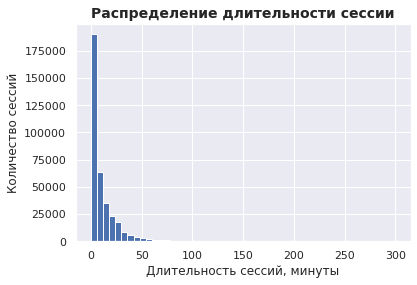

In [ ]:
visits['session_duration_minute'].hist(bins=50, range=(0,300))
plt.xlabel('Длительность сессий, минуты')
plt.ylabel('Количество сессий')
plt.title('Распределение длительности сессии', fontweight='bold', fontsize=14)
plt.show()

**Т.к. распределение не близко к нормальному, то смотреть на среднюю или медиану будет не корректно. Поэтому, рассчитаем моду длительности сессии.**

Напишем функцию, которая:
  - будет вычислять границы усов: значения 25% перцентили минус 1.5 х МКР и значения 75% перцентили плюс 1.5 х МКР (МКР - межквартальных размах).
  - вычисляет долю выбросов (значений, которые находятся за границами усов)

In [ ]:
def wrong_ratio(data, column):
    p_25, p_75 = np.percentile(data[column], [25, 75]) #значения квартилей
    iqr = p_75 - p_25 #межквартальный размах
    upper_bound = round(p_75 + 1.5 * iqr, 2)
    lower_bound  = round(p_25 - 1.5 * iqr, 2)
    if upper_bound > data[column].max():
        upper_bound = data[column].max()
    if lower_bound < data[column].min():
        lower_bound = data[column].min()
    print('\033[1m' + column + ':', 'Доля выбросов составляет: {:.1%}'.format(len(data.loc[data[column] > upper_bound]) / len(data)))
    print('\033[1m' +'Большинство значений лежит в интервале от', lower_bound, 'до',  upper_bound)

In [ ]:
print('\033[1m' +'Средняя продолжительность сессии:', float(visits['session_duration_minute'].mode()),'(мин)')
wrong_ratio(visits, 'session_duration_minute')

Средняя продолжительность сессии: 1.0 (мин)
session_duration_minute: Доля выбросов составляет: 6.9%
Большинство значений лежит в интервале от 0.0 до 32.0


<a id="2.1"></a>
<a id="2.2"></a>
### - **Сколько людей пользуются в день, неделю, месяц?**
### - **Сколько сессий в день?**

**Вычислим количество сессий в день, DAU, WAU, MAU, sticky factor (недельный), sticky factor (месячный)**

In [ ]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
all_visits_day = visits.groupby('session_date')['uid'].count().mean()
wau_total = visits.groupby(['year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby('session_year_month').agg({'uid': 'nunique'}).mean()

sticky_wau = dau_total/wau_total
sticky_mau = dau_total/mau_total
print('\033[1m' +'Количество сессий в день:', int(all_visits_day))
print('\033[1m' +'DAU (количество уникальных пользователей в день):', int(dau_total))
print('\033[1m' +'WAU (количество уникальных пользователей в неделю):', int(wau_total))
print('\033[1m' +'MAU (количество уникальных пользователей в месяц):', int(mau_total))
print('___________________________________________________________')
print('\033[1m' +'sticky factor (недельный): {:.1%}'.format(float(sticky_wau)))
print('\033[1m' +'sticky factor (месячный): {:.1%}'.format(float(sticky_mau)))

Количество сессий в день: 987
DAU (количество уникальных пользователей в день): 907
WAU (количество уникальных пользователей в неделю): 5716
MAU (количество уникальных пользователей в месяц): 23228
___________________________________________________________
sticky factor (недельный): 15.9%
sticky factor (месячный): 3.9%


**Выводы:**
1. **Количество сессий в день и DAU очень близки. Это значит, что в среднем каждый пользователь заходит на ресурс лишь 1 раз в день.**
2. **sticky factor (месячный) составляет всего 3.9%. Этот показатель позволяет оценить регулярность посещений. Величина 3.9% говорит о том, что пользователи не задерживаются на сайте и не посещают его регулярно в течение месяца.**


Посмотрим как меняются MAU, WAU, DAU во времени.

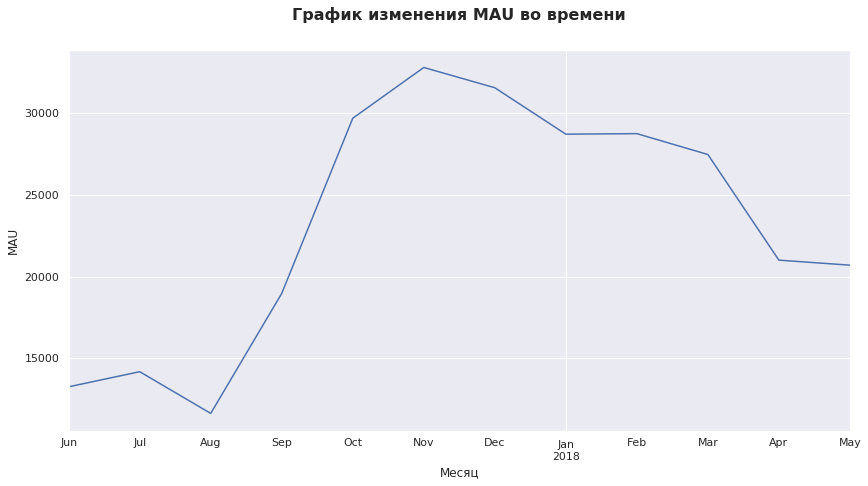

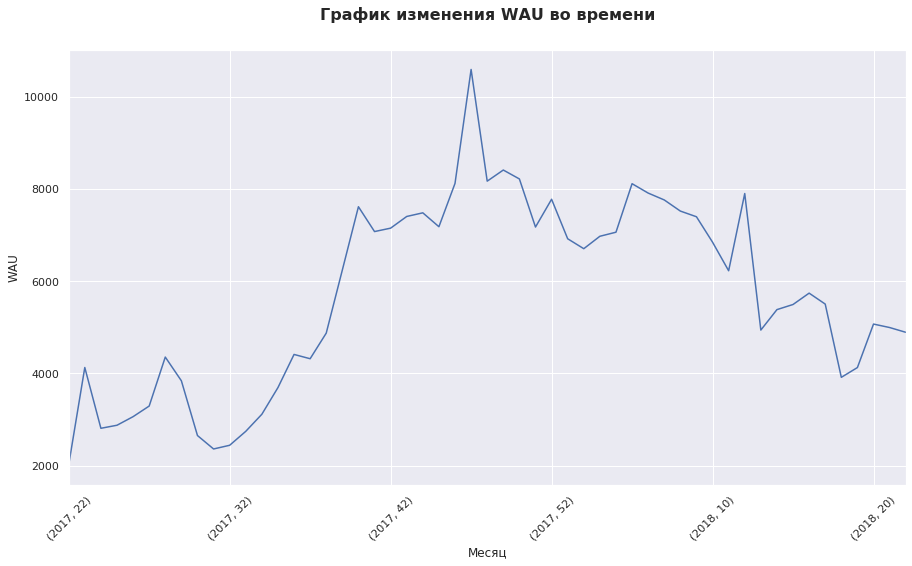

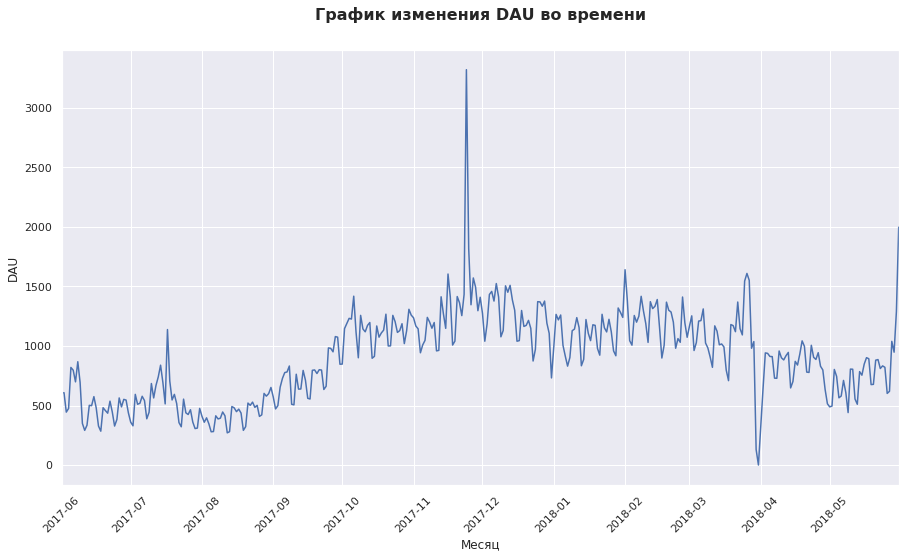

In [ ]:
import matplotlib.ticker as ticker
visits.groupby('session_year_month').agg({'uid': 'nunique'}).plot(legend=False, figsize=(14, 7))
plt.title('График изменения MAU во времени', fontsize=16, pad=30, fontweight='bold')
plt.ylabel('MAU')
plt.xlabel('Месяц')
plt.show()
visits.groupby(['year', 'session_week']).agg({'uid': 'nunique'}).plot(legend=False, figsize=(15, 8))
plt.title('График изменения WAU во времени', fontsize=16, pad=30, fontweight='bold')
plt.ylabel('WAU')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.show()
visits.groupby('session_date').agg({'uid': 'nunique'}).plot(legend=False, figsize=(15, 8))
plt.title('График изменения DAU во времени', fontsize=16, pad=30, fontweight='bold')
plt.ylabel('DAU')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.show()

<a id="2.4"></a>
### - **Как часто люди возвращаются?**

**Посчитаем Retention Rate (Коэффициент удержания)**

In [ ]:
first_session_date = visits.groupby('uid')['start_ts'].min()
first_session_date.name = 'first_session_date'
visits = visits.join(first_session_date, on='uid')
visits['first_session_date'] = visits['first_session_date'].astype('datetime64[M]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['session_month'] - visits['first_session_date']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_week,year,session_year_month,session_duration_minute,first_session_date,session_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,2017,2017-12,18.0,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2018,2018-02,28.0,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,2017,2017-07,0.0,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,2018,2018-05,24.0,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,2017,2017-12,0.0,2017-12-01,2017-12-01,0


In [ ]:
cohorts_ret = (visits
                       .groupby(['first_session_date', 'cohort_lifetime'])
                       .agg({'uid': 'nunique'})
                       .reset_index())
cohorts_ret.head()

,first_session_date,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю.

In [ ]:
init_users_count = cohorts_ret[cohorts_ret['cohort_lifetime']==0][['first_session_date', 'uid']]
init_users_count = init_users_count.rename(columns={'uid': 'cohort_users'})
init_users_count.head()

,first_session_date,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


In [ ]:
cohorts_ret = cohorts_ret.merge(init_users_count, on='first_session_date')
cohorts_ret['retention'] = cohorts_ret['uid']/cohorts_ret['cohort_users']

retention_pivot_rel = cohorts_ret.pivot_table(index='first_session_date', columns='cohort_lifetime',
                                      values='retention', aggfunc='sum')

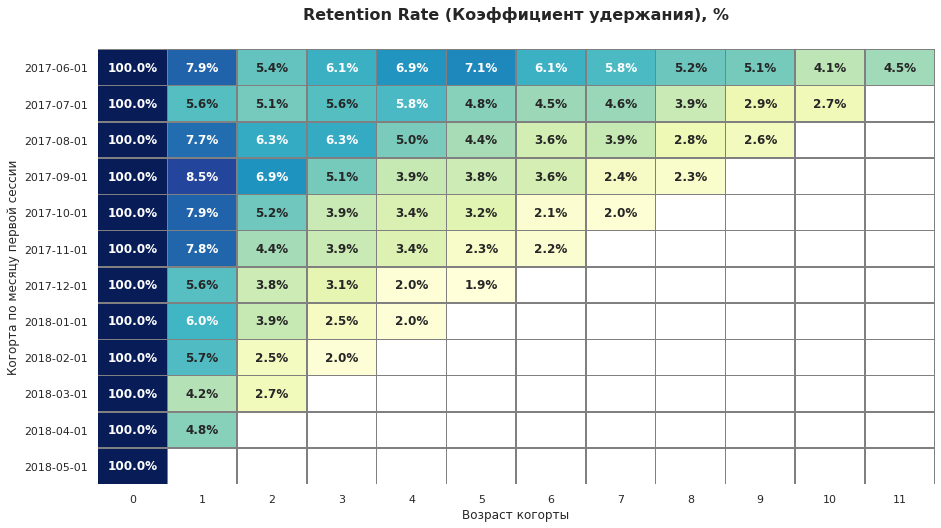

In [ ]:
sns.set(style='white')
plt.figure(figsize=(15, 8))
sns.heatmap(retention_pivot_rel, annot=retention_pivot_rel.values, linecolor='gray', cmap='YlGnBu', 
            fmt='.1%', linewidths=.5, annot_kws={"weight": "bold", "size": 12}, vmax=.1, 
            cbar=False).set_yticklabels(retention_pivot_rel.index.date)
plt.title('Retention Rate (Коэффициент удержания), %', fontsize=16, pad=30, fontweight='bold')
plt.ylabel('Когорта по месяцу первой сессии')
plt.xlabel('Возраст когорты')
plt.show()

**Вывод:**  
- **Retention довольно низкий. Retention второго месяца пользования нашим ресурсом находится в интервале от 4,2 до 8,5% в зависимости от когорты. C течением времени, этот процент падает до 1,9-2,7%.** <br>     
- **Это справедливо для всех когорт, кроме самой первой, которая начала пользоваться ресурсом в июне 2017 года. Их Retention тоже довольно низкий, но постоянно находится в "лидерах" по сравнении со всеми остальными когортами. А на пятый месяц жизни когорты Retention даже начинает расти до 6,9-7,1%.**


### **2.2 Продажи:**
- **Когда люди начинают покупать?**
- **Сколько раз покупают за период?**
- **Какой средний чек?**
- **Сколько денег приносят? (LTV)**

Для ответов на вопросы работать будет с таблицами `orders` и `visits`

<a id="2.5"></a>
### - **Когда люди начинают покупать?**

Сгруппируем таблицы `orders` и `visits` по пользователям, чтобы найти дату первого заказа и дату первой сессии. Затем объединим их в одну таблицу `session_buy_date` и добавим столбец с разницей в минутах между датой и временем первого заказа и датой и временем первой сессии.

In [ ]:
first_buy_date = orders.groupby('uid')[['buy_ts']].min().reset_index()
first_buy_date.columns = ['uid', 'first_buy_date']
first_session_date = visits.groupby('uid')[['start_ts']].min().reset_index()
first_session_date.columns = ['uid', 'first_session_date']
session_buy_date = first_buy_date.merge(first_session_date, on='uid')
session_buy_date['buy_diff'] = session_buy_date['first_buy_date'] - session_buy_date['first_session_date']
session_buy_date['buy_diff'] = session_buy_date['buy_diff']/np.timedelta64(1, 'm')
session_buy_date['buy_diff'] = session_buy_date['buy_diff'].round(1)
session_buy_date.head()

,uid,first_buy_date,first_session_date,buy_diff
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


Сгруппируем таблицу по пользователям и выберем минимальную разницу по времени (т.е. разницу между первой сессией и первой покупкой).
Анализируя лог с посещением сервиса, мы выяснили, что большинство всех сессий короче 32 минут. Для построения диаграммы boxplot возьмем срез сгруппированной таблицы (разница между первой сессией и первым заказом менее 32 мин) 

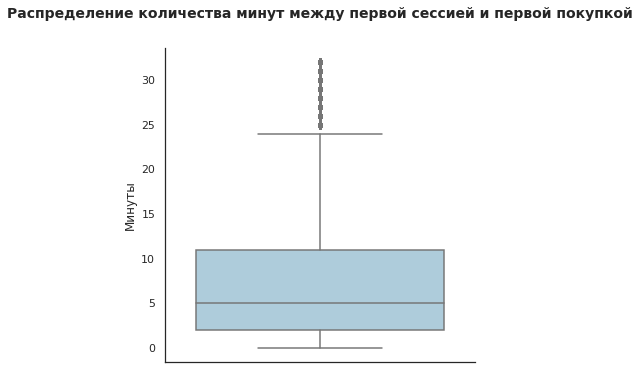

In [ ]:
buy_diff = session_buy_date.groupby('uid')[['buy_diff']].min()
sns.catplot(data=buy_diff.query('buy_diff <= 32'), kind="box", palette='Paired').set_xticklabels('')
plt.title('Распределение количества минут между первой сессией и первой покупкой', fontsize=14, pad=30, fontweight='bold')
plt.ylabel('Минуты')
plt.show()

In [ ]:
wrong_ratio(buy_diff.query('buy_diff <= 32'), 'buy_diff')

buy_diff: Доля выбросов составляет: 4.5%
Большинство значений лежит в интервале от 0.0 до 24.5


Посмотрим на гистограмму распределения между временем первого заказа и временем первой сессии.

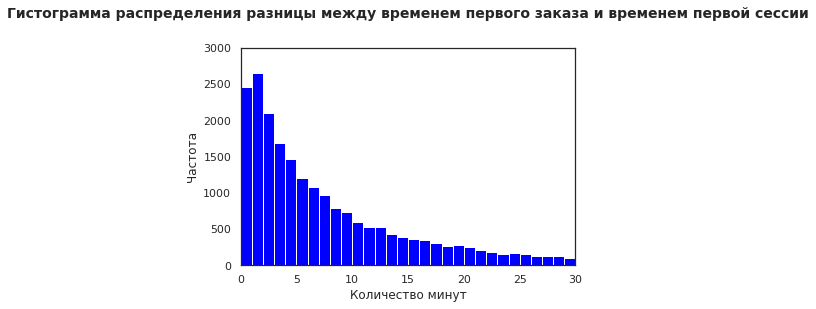

In [ ]:
buy_diff.query('buy_diff <= 32').plot.hist(
                                bins=32,
                                xlim=(0, 30),
                                ylim=(0,3000),
                                legend=False,
                                color='blue')
plt.title('Гистограмма распределения разницы между временем первого заказа и временем первой сессии', fontsize=14, pad=30, fontweight='bold')
plt.xlabel('Количество минут')
plt.ylabel('Частота')
plt.show()

**Вывод: С увеличением времени на оформление заказа, количество заказов уменьшается Т.е. если пользователи заходят на ресурс, то они делают заказ в течение нескольких минут.**


<a id="2.6"></a>
### - **Сколько раз покупают за период?**

За период возьмем месяц. Посмотрим, сколько покупок совершает каждый пользователь в месяц.

In [ ]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [ ]:
orders = orders.merge(first_buy_date, on='uid')
orders.head()

,buy_ts,revenue,uid,first_buy_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


Теперь добавим столбец diff_month, где будет в месяцах указано время "пребывания" каждого пользователя с момента первого визита на момент конкретного заказа:

In [ ]:
orders['month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_month'] = orders['first_buy_date'].astype('datetime64[M]')
orders['diff_month'] = orders['month'] - orders['first_month']
orders['diff_month'] = (orders['diff_month'] / np.timedelta64(1,'M')).round(0).astype('int') 
orders.head()

,buy_ts,revenue,uid,first_buy_date,month,first_month,diff_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0


Выделим когорты по первой сессии и по месяцам, посчитаем количество заказов за данный конкретный месяц, количество уникальных пользователей и количество заказов на одного пользователя:

In [ ]:
cohorts_orders = (orders
                         .groupby(['first_month','diff_month'])
                         .agg({'month': 'count', 'uid': 'nunique'})
                  )
cohorts_orders = cohorts_orders.reset_index()
cohorts_orders.columns = ['first_month', 'diff_month', 'n_purchases', 'n_customers']
cohorts_orders['purchases_per_customer'] = cohorts_orders['n_purchases']/cohorts_orders['n_customers']
cohorts_orders['purchases_per_customer'] = cohorts_orders['purchases_per_customer'].round(2)
cohorts_orders.head()

,first_month,diff_month,n_purchases,n_customers,purchases_per_customer
0,2017-06-01,0,2354,2023,1.16
1,2017-06-01,1,177,61,2.90
2,2017-06-01,2,174,50,3.48
3,2017-06-01,3,226,54,4.19
4,2017-06-01,4,292,88,3.32


In [ ]:
purchases_pivot = cohorts_orders.pivot_table(index='first_month', 
                                            columns='diff_month', 
                                            values='purchases_per_customer')

Отобразим heatmap для сводной таблицы `purchases_pivot`

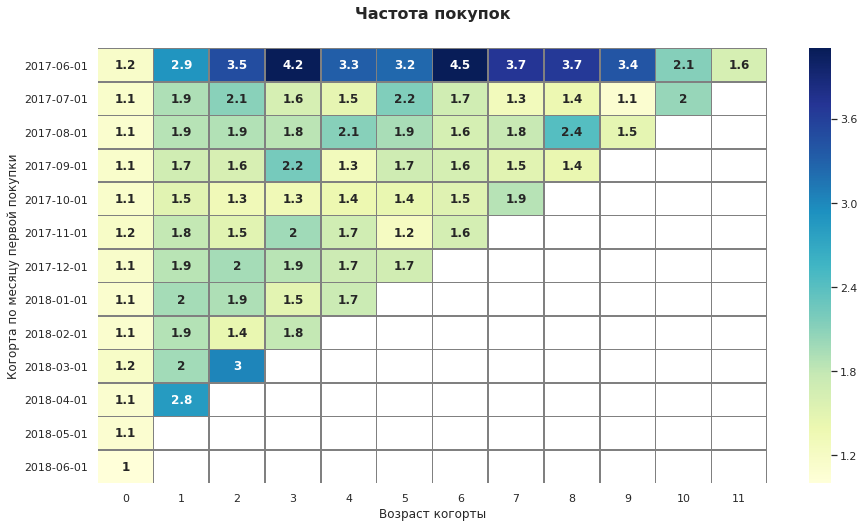

In [ ]:
sns.set(style='white')
plt.figure(figsize=(15, 8))
sns.heatmap(purchases_pivot, annot=purchases_pivot.values, linecolor='gray', cmap='YlGnBu', 
            linewidths=.5, annot_kws={"weight": "bold", "size": 12}, vmax=4.1,
            cbar=True).set_yticklabels(purchases_pivot.index.date)
plt.title('Частота покупок', fontsize=16, pad=30, fontweight='bold')
plt.ylabel('Когорта по месяцу первой покупки')
plt.xlabel('Возраст когорты')
plt.show()

- Первая когорта опять выделяется, в среднем делает более 3 заказов в месяц.

- Первый месяц все пользователи присматриваются к сервису, а начиная со второго в среднем делают около 2-х заказов в месяц.

- Апрельская когорта выдялется тем, что на второй месяц использования ресурса практически 3 покупки на клиента, в сравнении с остальными когортами, где, в большинстве, не дотягивает даже до значения в 2-х покупок, это выглядит довольно странно, как и 3-й месяц у мартовской когорты.


<a id="2.7"></a>
### - **Какой средний чек?**

 Найдем, какой был средний чек по каждой когорте по месяцам и отобразим на heatmap:

In [ ]:
first_buy_date['first_buy_date'] = first_buy_date['first_buy_date'].astype('datetime64[M]')
cohort_sizes = first_buy_date.groupby('first_buy_date').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_month', 'n_buyers']
orders_first_buy_date = orders.merge(first_buy_date, on='uid')
cohorts = (orders_first_buy_date.groupby(['month', 'first_month'])
                                .agg({'revenue': 'sum', 'uid': 'count'})
                                .reset_index())
mean_check = cohorts.merge(cohort_sizes, on='first_month')
time_diff = mean_check['month'] - mean_check['first_month']
mean_check['age'] = (time_diff / np.timedelta64(1,'M')).round(0).astype('int')
mean_check['mean_check'] = mean_check['revenue']/mean_check['uid']
print('\033[1m' +'Средний (медианный) чек равен:', mean_check['mean_check'].median().round(1), 'у.е.')

Средний (медианный) чек равен: 5.6 у.е.


In [ ]:
print('\033[1m' +'Средний (медианный) чек за первый месяц жизни когорты:', mean_check[mean_check['age']==0]['mean_check'].median().round(1), 'у.е.')


Средний (медианный) чек за первый месяц жизни когорты: 4.2 у.е.


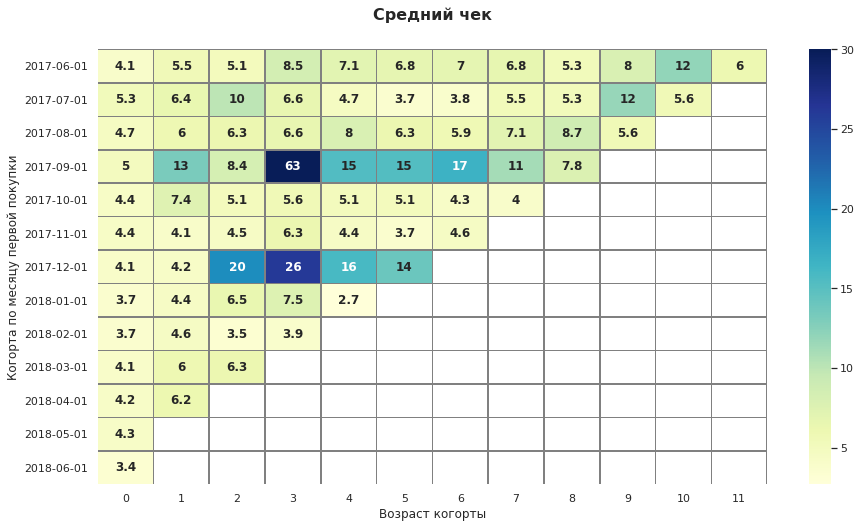

In [ ]:
mean_check_pivot = mean_check.pivot_table(index="first_month", columns="age", values="mean_check")
sns.set(style='white')
plt.figure(figsize=(15, 8))
sns.heatmap(mean_check_pivot, annot=mean_check_pivot.values, linecolor='gray', cmap='YlGnBu', 
            linewidths=.5, annot_kws={"weight": "bold", "size": 12}, vmax=30,
            cbar=True).set_yticklabels(mean_check_pivot.index.date)
plt.title('Средний чек', fontsize=16, pad=30, fontweight='bold')
plt.ylabel('Когорта по месяцу первой покупки')
plt.xlabel('Возраст когорты')
plt.show()

**Вывод:**
- **Средний чек равен примерно 5,6 у.е.**
- **Замечено несколько аномальных когорт - сентябрьская и декабрьская. По ним средний чек после двух-трех первых месяцев превышал 10 у.е.**
- **У большинства когорт на второй месяц средний чек больше, чем в первый месяц**
- **В когортах - июньская и июльская: высокие значения выручки в сентябре**
- **В когортах - июньская, июльская, августовская, январская: высокие значения выручки также отмечены в сентябре. Возможно есть сезонность**


<a id="2.8"></a>
### - **Сколько денег приносят? (LTV)**

Рассчитаем LTV (lifetime value) - показатель прибыли, которую компания получает от одного клиента за все время работы с ним. Для расчета LTV маржинальность примем равной 100%. 

In [ ]:
margin_rate = 1
cohorts = (orders_first_buy_date.groupby(['month', 'first_month'])
                                .agg({'revenue': 'sum'})
                                .reset_index())
LTV = cohorts.merge(cohort_sizes, on='first_month')
LTV['gp'] = LTV['revenue'] * margin_rate
LTV['age'] = (LTV['month'] - LTV['first_month']) / np.timedelta64(1, 'M')
LTV['age'] = LTV['age'].round(0).astype('int')
LTV['ltv'] = LTV['gp'] / LTV['n_buyers']
LTV_pivot = LTV.pivot_table(index="first_month",
            columns="age",
            values="ltv",
            aggfunc='mean')

Отобразим `LTV_pivot` на heatmap.

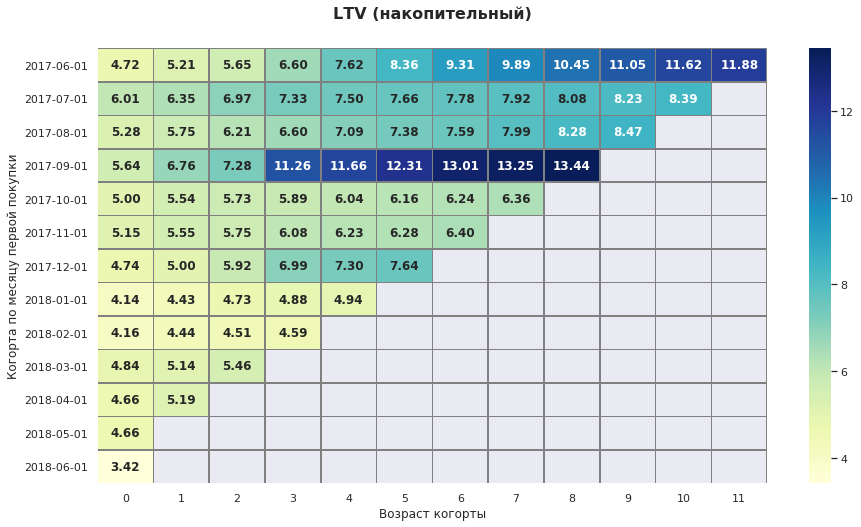

In [ ]:
LTV_pivot_cumsum = LTV_pivot.cumsum(axis=1)
sns.set(style='darkgrid')
plt.figure(figsize=(15, 8))
sns.heatmap(LTV_pivot_cumsum, annot=LTV_pivot_cumsum.values, linecolor='gray', cmap='YlGnBu', 
            linewidths=.5, annot_kws={"weight": "bold", "size": 12}, fmt='.2f', 
            cbar=True).set_yticklabels(LTV_pivot_cumsum.index.date)
plt.title('LTV (накопительный)', fontsize=16, pad=30, fontweight='bold')
plt.ylabel('Когорта по месяцу первой покупки')
plt.xlabel('Возраст когорты')
plt.show()

In [ ]:
m6_cum_ltv = LTV_pivot_cumsum.mean(axis=0)[5]
print('\033[1m' + 'Средний LTV за 6 месяцев:', m6_cum_ltv.round(2))

Средний LTV за 6 месяцев: 7.97


**Вывод:**
- Выше представлены два графика:
    - LTV (значение LTV в каждый отдельный месяц),
    - LTV (накопительный). 
- Замечено, что первые когорты (с июня по сентябрь 2017 года) были более "качественные", чем последующие - их накопительный LTV выше, чем по остальным когортам.
- Первая когорта опять выделяется - практически в каждом месяце она показывала лучший результат по LTV среди всех когорт. Как отмечали ранее у нее также был самые высокие Retention и количество покупок на одного покупателя.
- У сентябрьской когорты на 3-й месяц жизни есть аномальный всплеск месячного значения LTV практически на 4 у.е.

### **2.3 Маркетинг:**
   - **Сколько денег потратили? Всего / на каждый источник / по времени**
   - **Сколько стоило привлечение одного покупателя из каждого источника?**
   - **На сколько окупились расходы? (ROI)**

Работать будем с таблицами `costs` (для анализа затрат) и `orders` (для анализа выручки).

<a id="2.9"></a>
### - **Сколько денег потратили? Всего / на каждый источник / по времени**

Сначала подготовим данные и создадим таблицу с 2-мя строками и 1-им столбцом, где будут указаны суммарная выручка и суммарные затраты:

In [ ]:
display(orders.head(3))
display(costs.head(3))

,buy_ts,revenue,uid,first_buy_date,month,first_month,diff_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


In [ ]:
costs_copy = costs.copy()

costs_copy['dt'] = costs_copy['dt'].values.astype('datetime64[M]') 
costs_grouped = costs_copy.groupby('dt').agg({'costs': 'sum'})
orders_grouped = orders.groupby('month').agg({'revenue': 'sum'})

data = {'summary': [round(orders_grouped.sum().values[0], 2),round(costs_grouped.sum().values[0], 2)]}
rev_costs = pd.DataFrame(data=data, index=['revenue', 'costs'])
display(rev_costs)
print('Отношение затрат к выручке:', rev_costs['summary']['costs'] / rev_costs['summary']['revenue'])

,summary
revenue,252057.20
costs,329131.62


Отношение затрат к выручке: 1.3057814654768838


- **Суммарная выручка = 252057,20**
- **Суммарные затраты = 329131,62**
- **Затраты примерно в 1,3 раза превышают выручку**

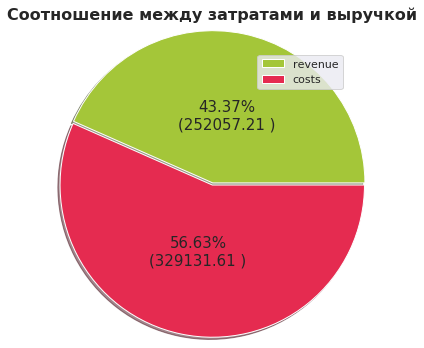

In [ ]:
def func_pct(pct):
    value = float(pct/100.*rev_costs.values.sum())
    return "{:.2f}%\n({:.2f} )".format(pct, value)

rev_costs.plot(kind='pie', y='summary', fontsize=15, use_index=False, shadow=True, explode=(0.02, 0),
                        pctdistance=0.45, figsize=(15,5), colors=['#a4c639', '#e52b50'], labels=None, 
               autopct=lambda pct: func_pct(pct), radius=1.4)
plt.title('Соотношение между затратами и выручкой', fontsize=16, pad=30, fontweight='bold')
plt.ylabel('')
plt.xlabel('')
plt.show()

**Затраты превышают выручку, пока что бизнес работает в убыток. Категоричных выводов делать рано, возможно маркетинговые вложения окупятся в перспективе**

Посмтротрим на затраты на рекламу по времени в разбивке по рекламным каналам

In [ ]:
costs_by_source = (costs
                      .groupby(['source_id', 'dt'])['costs']
                      .sum()
                      .reset_index()
                     )
costs_by_source['dt'] = costs_by_source['dt'].dt.to_period('M')
costs_by_source = costs_by_source.groupby(['source_id', 'dt'])['costs'].sum().reset_index()
costs_by_source.sample(5)

,source_id,dt,costs
82,10,2018-04,388.25
24,3,2017-06,7731.65
56,5,2018-02,5071.31
40,4,2017-10,6420.84
27,3,2017-09,9963.55


In [ ]:
costs_by_source_pivot = costs_by_source.pivot_table(index='source_id',
            columns='dt',
            values='costs',
            aggfunc='mean')

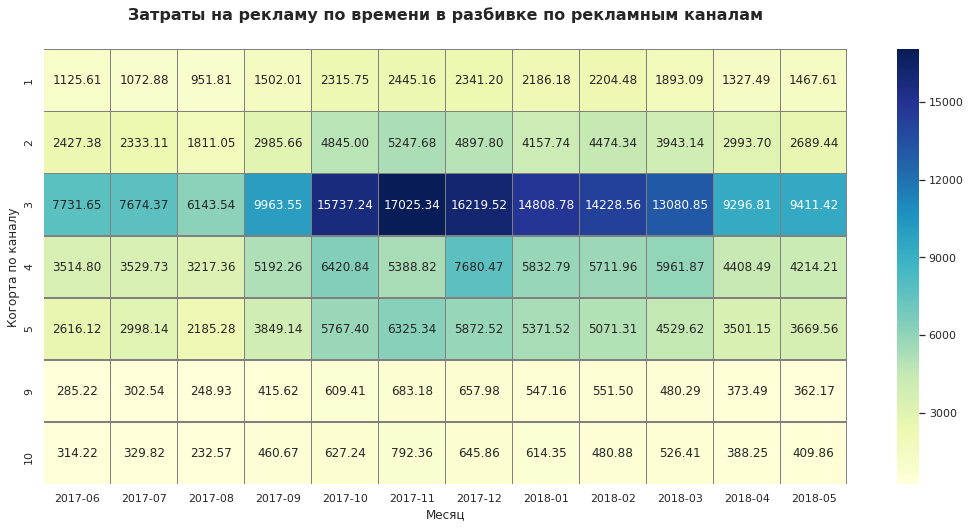

In [ ]:
sns.set(style='whitegrid')
plt.figure(figsize=(18, 8))
sns.heatmap(costs_by_source_pivot, annot=costs_by_source_pivot.values, linecolor='gray', cmap='YlGnBu', 
            linewidths=.5, annot_kws={"size": 12}, fmt='.2f',
            cbar=True).set_xticklabels(costs_by_source_pivot.columns)
plt.title('Затраты на рекламу по времени в разбивке по рекламным каналам', fontsize=16, pad=30, fontweight='bold')
plt.ylabel('Когорта по каналу')
plt.xlabel('Месяц')
plt.show()

**Вывод:**
- Начиная с августа 2017г. вложения в рекламу начали увеличиваться. В ноябре 2017 года они достигли максимальных значений практически по всем рекланым каналам, кроме канала №4, где максимум зафиксирован в декабре 2017 года.
- Самый активный период инвестиций в рекламу - с октября 2017г. по март 2018г.


<a id="2.10"></a>
### - **Сколько стоило привлечение одного покупателя из каждого источника?**

Для ответа на вопрос найдем затраты и выручку по каналам.

In [ ]:
print('\033[1m' + 'Затраты по каналам:')
costs_per_source = costs.groupby('source_id').agg({'costs': 'sum'})
display(costs_per_source.sort_values(by='costs', ascending=False))
print('\033[1m' + '______________________________')
print('\033[1m' + 'Выручка по каналам:')
visits_sorted = visits.sort_values(by='start_ts')
first_source_per_user = visits_sorted.groupby('uid').agg({'source_id': 'first'})
client_per_source = orders.merge(first_source_per_user, on='uid')
client_per_source = client_per_source.groupby('source_id').agg({'uid': 'nunique'})
uid_per_source = visits_sorted.groupby('source_id').agg({'uid': 'nunique'})
rev_per_source = orders.merge(first_source_per_user, on='uid')
rev_per_source = rev_per_source.groupby('source_id').agg({'revenue': 'sum'})
display(rev_per_source.sort_values(by='revenue', ascending=False))

Затраты по каналам:


,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


______________________________
Выручка по каналам:


,revenue
source_id,
4,56696.83
3,54511.24
5,52624.02
2,46923.61
1,31090.55
9,5759.40
10,4450.33
7,1.22


Больше всего затрат идет на канал №3, хотя он не является лидером по выручке. Больше всего денег приносит канал №4. Объединим информацию в одну таблицу и добавим столбцы с затратами на одного клиента и выручкой на одного клиента.

In [ ]:
rev_uid_costs_per_source = pd.concat([costs_per_source, rev_per_source, 
                                      uid_per_source, client_per_source],axis=1).fillna(0)
rev_uid_costs_per_source.columns = ['costs', 'revenue', 'uid', 'clients']
rev_uid_costs_per_source = rev_uid_costs_per_source
rev_uid_costs_per_source['price_for_client'] = (rev_uid_costs_per_source['costs']/
                                                rev_uid_costs_per_source['clients'])
rev_uid_costs_per_source['revenue_for_client'] = (rev_uid_costs_per_source['revenue']/
                                                rev_uid_costs_per_source['clients'])
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['price_for_client'].round(2)
rev_uid_costs_per_source['revenue_for_client'] = rev_uid_costs_per_source['revenue_for_client'].round(2)
rev_uid_costs_per_source['ctr_%'] = round(rev_uid_costs_per_source['clients'] / rev_uid_costs_per_source['uid'] * 100, 1)
rev_uid_costs_per_source.sort_values(by='price_for_client', ascending=False).fillna(0)

,costs,revenue,uid,clients,price_for_client,revenue_for_client,ctr_%
source_id,,,,,,,
3,141321.63,54511.24,74756,10473.0,13.49,5.20,14.0
2,42806.04,46923.61,26245,3506.0,12.21,13.38,13.4
5,51757.10,52624.02,56974,6931.0,7.47,7.59,12.2
1,20833.27,31090.55,18999,2899.0,7.19,10.72,15.3
4,61073.60,56696.83,83525,10296.0,5.93,5.51,12.3
9,5517.49,5759.40,9264,1088.0,5.07,5.29,11.7
10,5822.49,4450.33,8067,1329.0,4.38,3.35,16.5
7,0.00,1.22,34,1.0,0.00,1.22,2.9
6,0.00,0.00,6,0.0,0.00,0.00,0.0


 **Выводы:**
- Каналы №1, №2, №5 и №9 работают достаточно эффективно: выручка выше затрат;
- Канал №3, в который инвестируем больше всего, является убыточным и также является самым дорогим каналом по привлечению клиента;
- Канал №4 также невыгоден, т.к. расходы превышают доход, тем не менее он является лидером по количеству привлеченных пользователей, даже по сравнению с 3 каналом, в который вложено в 2,5 раза больше;
- Каналы № 6 и №7: в них не было затрат на привлечение клиентов, хотя на двоих они привлекли 40 новых пользователей, из них только 1 стал клиентом, и он принес нам 1,22 у.е. выручки;
- Канал №10 канал убыточный;
- Каналы №1, №2 и №5 выглядят перспективными с точки зрения доходов, т.к. являются прибыльными и привлекают тех клиентов, кто совершает достаточно большие покупки;
- В связи с этим, рекомендутся перераспределить вложения в рекламные каналы. Часть затрат канала №3 направить на самые перспективные каналы №1, №2 и №5. 
- По каналам №3, №4 и №10 необходимо провести исследования и понять почему они убыточные, особенно по каналу №10, ведь у него самая высокая конверсия пользователей в покупателей. (16,5%)
- Также требуется более подробности изучить каналы №6 и №7, т.к. даже без инвестиций в рекламу они привлекают пользователей и даже привлекли одного покупателя.

**Анализ посещаемости ресурса по типу устройства.**
-  Для этого обратимся к таблице visits

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_week,year,session_year_month,session_duration_minute,first_session_date,session_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,2017,2017-12,18.0,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2018,2018-02,28.0,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,2017,2017-07,0.0,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,2018,2018-05,24.0,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,2017,2017-12,0.0,2017-12-01,2017-12-01,0


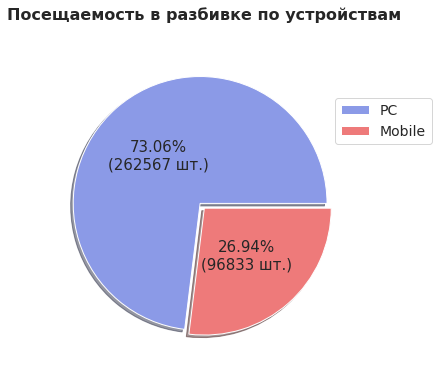

In [ ]:
visits_by_device = visits.groupby('device').agg({'uid': 'count'})
summary = visits_by_device.values.sum()

def func_pct(pct):
    value = float(pct/100.*summary)
    return "{:.2f}%\n({:.0f} шт.)".format(pct, value)

explode = (0.05, 0)

ax_pie = visits_by_device.plot(kind='pie', y='uid', fontsize=15, use_index=False, shadow=True, 
                               explode=explode, pctdistance=0.5, figsize=(15,5), autopct=lambda pct: func_pct(pct), 
                               colors=['#8b9ae7', '#ee7a7a'], labels=None)
plt.title('Посещаемость в разбивке по устройствам', fontsize=16, pad=30, fontweight='bold')
plt.tight_layout(pad=0)

legend = ax_pie.legend(['PC', 'Mobile'], bbox_to_anchor=(0.89,0.87), prop={'size':14})
y_label = ax_pie.set_ylabel('')

**Вывод:**
- **Приблизительно 73% посещений нашего ресурса совершены с PC. С мобильных утройств достаточно низкий показатель: 27 %. Причина может быть в том, что с мобильного устройства сайт использовать не так удобно, как с компьютера**
- **Необходимо протестировать мобильную версию сайта по части удобства использования, чтобы установить, является ли это причиной низкого показателя посещаемости сайта.**

<a id="2.11"></a>
### - **На сколько окупились расходы? (ROMI)**

Ранее мы уже формировали таблицу с LTV. Воспользуемся ей, чтобы посчитать CAC и ROMI. Для расчета ROMI воспользуемся упрощенной формулой: `ROMI = LTV / CAC * 100%`


In [ ]:
rev_uid_costs_per_source['LTV'] = round((rev_uid_costs_per_source['revenue'] * margin_rate) 
                                   / rev_uid_costs_per_source['clients'], 2)
rev_uid_costs_per_source['CAC'] = round(rev_uid_costs_per_source['costs'] / rev_uid_costs_per_source['clients'], 2)
rev_uid_costs_per_source['ROMI'] = round(rev_uid_costs_per_source['LTV'] / rev_uid_costs_per_source['CAC'], 2)
rev_uid_costs_per_source = rev_uid_costs_per_source.replace(np.inf, np.nan)
rev_uid_costs_per_source = rev_uid_costs_per_source.fillna(0)
rev_uid_costs_per_source.sort_values(by='ROMI', ascending=False)

,costs,revenue,uid,clients,price_for_client,revenue_for_client,ctr_%,LTV,CAC,ROMI
source_id,,,,,,,,,,
1,20833.27,31090.55,18999,2899.0,7.19,10.72,15.3,10.72,7.19,1.49
2,42806.04,46923.61,26245,3506.0,12.21,13.38,13.4,13.38,12.21,1.10
9,5517.49,5759.40,9264,1088.0,5.07,5.29,11.7,5.29,5.07,1.04
5,51757.10,52624.02,56974,6931.0,7.47,7.59,12.2,7.59,7.47,1.02
4,61073.60,56696.83,83525,10296.0,5.93,5.51,12.3,5.51,5.93,0.93
10,5822.49,4450.33,8067,1329.0,4.38,3.35,16.5,3.35,4.38,0.76
3,141321.63,54511.24,74756,10473.0,13.49,5.20,14.0,5.20,13.49,0.39
6,0.00,0.00,6,0.0,0.00,0.00,0.0,0.00,0.00,0.00
7,0.00,1.22,34,1.0,0.00,1.22,2.9,1.22,0.00,0.00


**Вывод:**
- Каналы, которые окупаются в порядке убывания ROMI - каналы №1, №2, №9, №5
- Самый затратный канал №3 не окупает себя, ROMI равен 0,39.
- Самыми лучшими выглядят каналы №1 и №2, у них высокая конверсия из пользователя в покупателя, самая лучшая окупаемость и самый высокий LTV.


Посмотрим выручку по каналу и устройству:

In [ ]:
first_visit = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visit.columns = ['uid', 'first_visit']
visits = visits.merge(first_visit)
revenue_by_source_and_device = ((orders.merge(visits.query('start_ts==first_visit'), on='uid', how='inner'))
                                .groupby(['source_id', 'device']).agg({'revenue':'sum'})).reset_index()

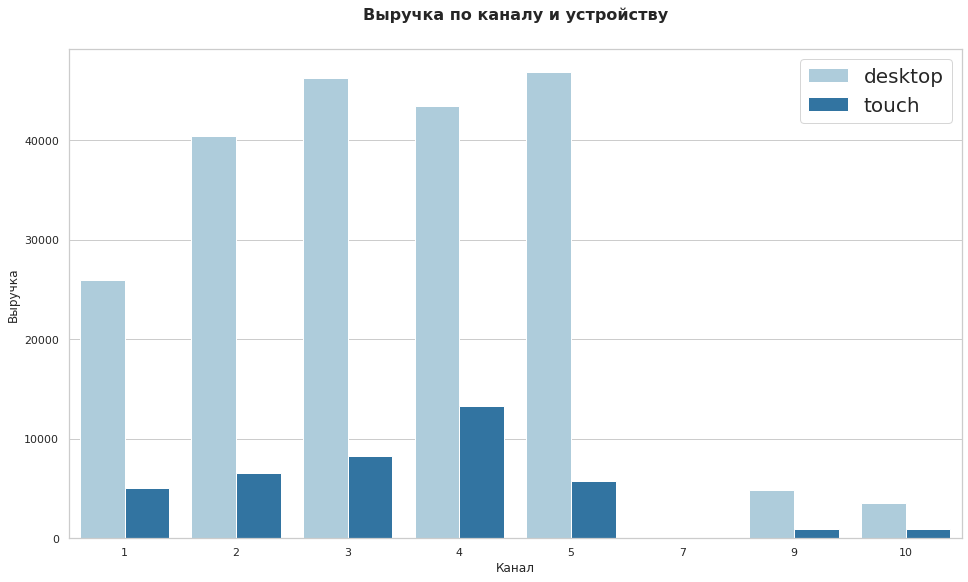

In [ ]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x='source_id', y='revenue', hue='device', data=revenue_by_source_and_device, palette='Paired')
plt.title('Выручка по каналу и устройству', fontsize=16, pad=30, fontweight='bold')
ax.set_xlabel('Канал')
ax.set_ylabel('Выручка')
plt.legend(fontsize = 20)
plt.show()

Посчитаем накопительный ROMI по каждой когорте и выведем heatmap.

In [ ]:
all_buyers = sum(LTV['n_buyers'].unique())
mean_check_prep = LTV.groupby('first_month').mean()
all_revenue = round(sum(mean_check_prep['revenue']), 2)
mean_check = round(sum(mean_check_prep['revenue']) / sum(mean_check_prep['n_buyers']), 2)
sum_revenue = round(sum(LTV['revenue']), 2)

In [ ]:
print('\033[1m' +'Средняя выручка в месяц:', all_revenue, 'у.е.')
print('\033[1m' +'Среднее число покупателей в месяц:', all_buyers)
print('\033[1m' +'Средняя выручка на покупателя в месяц:', mean_check, 'у.е.')

Средняя выручка в месяц: 55021.39 у.е.
Среднее число покупателей в месяц: 36523
Средняя выручка на покупателя в месяц: 1.51 у.е.


In [ ]:
costs_cac = costs.copy()
costs_cac['month'] = costs_cac['dt'].astype('datetime64[M]')
all_costs = costs_cac.groupby('month').agg({'costs':'sum'}).reset_index()
sum_costs = round(all_costs.sum().values[0], 2)
final_cac = LTV.merge(all_costs, left_on='month', right_on='month')
final_cac['cac'] = final_cac['costs']/final_cac['n_buyers']
final_cac['romi'] = final_cac['ltv']/final_cac['cac']
sum_gp = round(final_cac['gp'].sum(), 2)
profit = round(sum_gp - sum_costs, 2)

romi_pivot = final_cac.pivot_table(index='first_month', columns='age',
                                   values='romi', aggfunc='mean').round(2)


print('\033[1m' +'Суммарная выручка:', sum_revenue, 'у.е.')
print('\033[1m' +'Суммарные затраты:', sum_costs, 'у.е.')
print('\033[1m' +'Суммарная валовая прибыль:', sum_gp, 'у.е.')
print('\033[1m' +'Прибыль/Убыток:', profit, 'у.е.')

Суммарная выручка: 252057.2 у.е.
Суммарные затраты: 329131.62 у.е.
Суммарная валовая прибыль: 252053.78 у.е.
Прибыль/Убыток: -77077.84 у.е.


Отобразим heatmap для ROMI (накопительный)

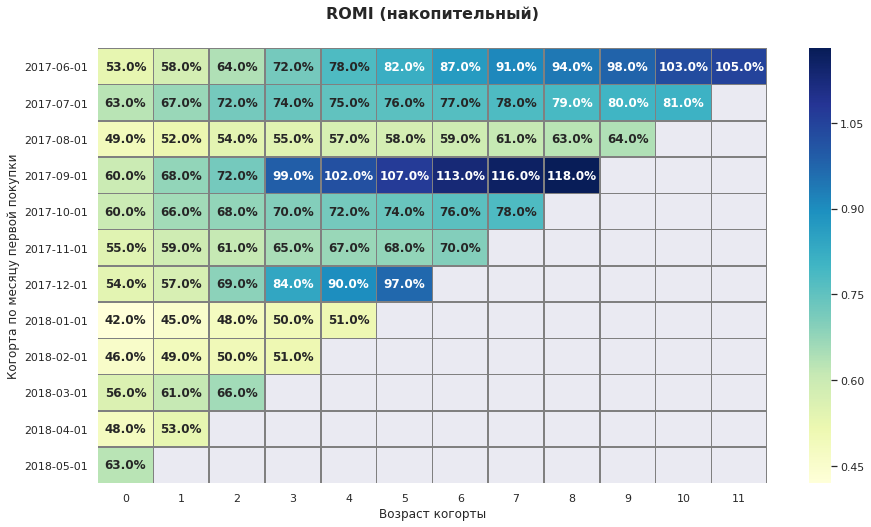

In [ ]:
romi_pivot_cumsum = romi_pivot.cumsum(axis=1)
sns.set(style='darkgrid')
plt.figure(figsize=(15, 8))
sns.heatmap(romi_pivot_cumsum, annot=romi_pivot_cumsum.values, linecolor='gray', cmap='YlGnBu', 
            linewidths=.5, annot_kws={"weight": "bold", "size": 12}, fmt='.1%', 
            cbar=True).set_yticklabels(romi_pivot_cumsum.index.date)
plt.title('ROMI (накопительный)', fontsize=16, pad=30, fontweight='bold')
plt.ylabel('Когорта по месяцу первой покупки')
plt.xlabel('Возраст когорты')
plt.show()

Посчитаем среднюю когорту — усредним ROMI всех когорт за каждый месяц их жизни и узнаем, как быстро в среднем когорты окупаются. 

In [ ]:
romi_pivot_cumsum.mean(axis=0)

age
0     0.540833
1     0.577273
2     0.624000
3     0.688889
4     0.740000
5     0.802857
6     0.803333
7     0.848000
8     0.885000
9     0.806667
10    0.920000
11    1.050000
dtype: float64

**Вывод:**
- Быстрее всех окупаются сентябрьская когорта (на 4-й месяц), на декабрьская (на 5-й месяц почти окупилась), июньская когорта окупилась на 11-й месяц.
- Остальные когорты не окупились на исследуемом промежутке времени. 
- В среднем когорты окупаются на 11-й месяц жизни;
- У сентябрьской когорты на 3-й месяц жизни есть аномальный всплеск месячного значения (аналогичное мы наблюдали при исследовании LTV);
- Хуже всего окупаются когорты августа, января и февраля.

<a id="3"></a>
### Шаг 3. Вывод.

**В рамках задачи оптимизации маркетинговых затрат сервиса Яндекс.Афиша сделаны следующие выводы:**
1. Открыли и изучили таблицы с данными:
    - visits (лог сервера с информацией о посещениях сайта);
    - orders (информация о заказах);
    - costs (информация о затратах на маркетинг);
2. Проверили данные на пропуски/дубликаты, заменили типы данных на корректные, а также скорректировали названия столбцов (привели названия столбцов к нижнему регистру и заменили пробелы на нижнее подчеркивание);
3. Посчитали продуктовые метрики и построили графики:
    - Средняя продолжительность сессии составляем 1 минуту, а продолжительность большинства сессий составляет от 0 до 32 минут; 
    - Количество сессий в день: 987;
    - DAU (количество уникальных пользователей в день): 907;
    - WAU (количество уникальных пользователей в неделю): 5716;
    - MAU (количество уникальных пользователей в месяц): 23228
    - Выяснили, что в среднем каждый пользователь заходит на ресурс лишь 1 раз в день;
    - Посчитали sticky factor (месячный), он составляет всего 3.9%. Он говорит о том, что пользователи не задерживаются на сайте и не посещают его регулярно в течение месяца;
    - Количество уникальных пользователей MAU, WAU растет с августа 2017 по нобярь 2017, далее начинает снижаться;
    - Посчитали как часто пользователи возвращаются: Retention довольно низкий. Retention второго месяца пользования нашим ресурсом находится в интервале от 4,2 до 8,5% в зависимости от когорты. C течением времени, этот процент падает до 1,9-2,7%;
    - По показателю Retention выделяет первая когорта (пользователи пришедшие в июне 2017 года), Retention в среднем выше на 2-3%.
4. Посчитали бизнес метрики ("Продажа"):
    - Выяснили при заходе на сервис пользователи делают заказ в течение нескольких минут;
    - Первый месяц все пользователи присматриваются к сервису, а начиная со второго в среднем делают около 2-х заказов в месяц;
    - Опять выделилась июньская когорта, в среднем совершают 3 заказа в месяц. Требуется дополнитьно изучить эту когорту и понять причины по которым они чаще пользуются сервисом и чаще покупают;
    - Средний (медианный) чек за первый месяц жизни когорты: 4.2 у.е.;
    - У большинства когорт на второй месяц средний чек больше, чем в первый месяц;
    - Также замечено у некоторых когорт: высокие значения выручки в сентябре;
    - Средний LTV за 6 месяцев равен: 7.97 у.е.;
    - Заметили, что первые когорты (с июня по сентябрь 2017 года) были более "качественные", чем последующие - их накопительный LTV выше, чем по остальным когортам.
5. Посчитали маркетинговые метрики:
    - Выяснили, что бизнес в текущем виде, убыточен: Затраты примерно в 1,3 раза превышают выручку;
    - Суммарные затраты на рекламу равны 329 131,62 у.е.;
    - Начиная с августа 2017г. вложения в рекламу начали увеличиваться. В ноябре 2017 года они достигли максимальных значений практически по всем рекланым каналам;
    - Самый активный период инвестиций в рекламу - с октября 2017г. по март 2018г.;
    - Проанализировали каналы привлечения покупателей:
        + Канал №3, в который инвестируем больше всего, является убыточным и также является самым дорогим каналом по привлечению клиента;
        + Каналы №4, 10 также убыточные;
        + Каналы №1, №2, №9 и №5 выглядят перспективными с точки зрения доходов, т.к. являются прибыльными и привлекают тех клиентов, кто совершает достаточно большие покупки. В связи с этим, рекомендутся перераспределить вложения в рекламные каналы. Часть затрат канала №3 направить на самые перспективные каналы №1, №2, №9 и №5; 
        + По каналам №3, №4 и №10 необходимо провести исследования и понять почему они убыточные.
        + Также требуется более подробности изучить каналы №6 и №7, т.к. даже без инвестиций в рекламу они привлекают пользователей и даже привлекли одного покупателя.
    - Проанализровали посещаемость сервиса с разных устройств:
        + Приблизительно 73% посещений нашего ресурса совершены с PC. С мобильных утройств достаточно низкий показатель: 27 %. Причина может быть в том, что с мобильного устройства сайт использовать не так удобно, как с компьютера;
        + Необходимо протестировать мобильную версию сайта по части удобства использования, чтобы установить, является ли это причиной низкого показателя посещаемости сайта.
    - Посчитали и проанализировали ROMI:
        + Быстрее всех окупаются сентябрьская когорта (на 4-й месяц), на декабрьская (на 5-й месяц почти окупилась), июньская когорта окупилась на 11-й месяц.
        + Остальные когорты не окупились на исследуемом промежутке времени. 
        + В среднем когорта окупается на 11-й месяц жизни;
        
**Резюмируя:**
- **На текущий момент бизнес убыточен;**
- **Сократить вложения в каналы №3, №4 и №10 и дополнительно понять причины их убыточности;**
- **Увеличить вложения в каналы №1, №2, №9 и №5;**
- **Дополнительно изучить каналы №6 и №7, т.к. даже без инвестиций в рекламу они привлекают пользователей и даже привлекли одного покупателя**
- **Необходимо посмотреть в сторону разработки мобильного приложения или повышения юзабилити сайта;**
- **Необходимо дополнительно исследовать клиентов первой когорты (которая выделялась по Ratention и LTV в лучшую сторону) и понять откуда клиенты пришли, чем им нравится ресурс и что заставляет возвращаться покупать снова**